In [6]:
!pip install --no-deps git+https://github.com/asztr/lombscargle.git

import torch
import numpy as np
from LombScargle import LS_omegas, LombScargleBatchMask

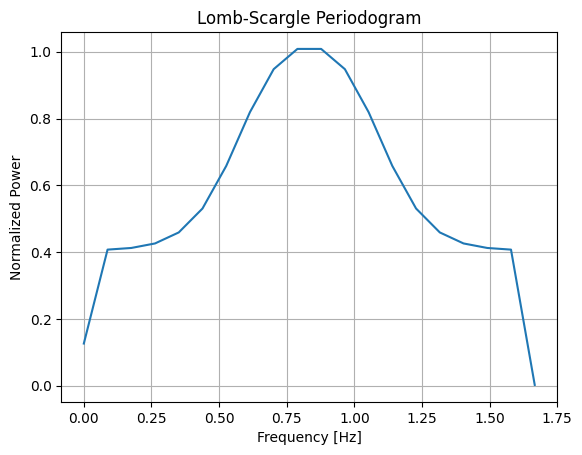

In [7]:
# Example time series (batch of 1)
t = torch.tensor([[0.1, 0.4, 0.7, 1.0]])
y = torch.tensor([[0.0, 1.0, 0.0, -1.0]])

# Compute angular frequencies
omegas = torch.tensor(LS_omegas(t[0].numpy(), samples_per_peak=5), dtype=torch.float32)

# Instantiate and compute periodogram
ls = LombScargleBatchMask(omegas)
P = ls(t, y, fap=True, norm=True)

# Plot the periodogram
import matplotlib.pyplot as plt

freqs = omegas.numpy() / (2 * np.pi)  # Convert to Hz
plt.plot(freqs, P.detach().numpy()[0])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalized Power")
plt.title("Lomb-Scargle Periodogram")
plt.grid(True)
plt.show()
